## Evaluate the ML models and produce verification diagrams 

In [1]:
# The custom classifier 
import sys, os
sys.path.insert(0, '/home/monte.flora/python_packages/WoF_post')
sys.path.insert(0, '/home/monte.flora/python_packages/ml_workflow')
sys.path.insert(0, '/home/monte.flora/python_packages/wofs_ml_severe')

from ml_workflow import TunedEstimator 
from wofs_ml_severe import load_ml_data
from wofs_ml_severe.io.load_ml_models import load_ml_model
from wofs_ml_severe.common.emailer import Emailer 
from wofs.post.utils import load_yaml
from verification_diagrams.verification_diagrams import plot_verification
from wofs_ml_severe.io.io import get_numeric_init_time

import numpy as np
from os.path import join
import joblib

def get_target_str(target):
    # Initialize the kwargs for the hyperparameter optimization.
    if isinstance(target, list):
        if 'sig_severe' in target[0]:
            target = 'all_sig_severe'
        else:
            target = 'all_severe'
   
    return target 

def fix_data(X): 
    #X = X.astype({'Initialization Time' : str})
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.reset_index(inplace=True, drop=True)
    
    return X 


BASE_PATH = '/work/mflora/ML_DATA/DATA/'

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


lookup_file: /home/monte.flora/python_packages/WoF_post/wofs/data/psadilookup.dat


### Load the Data and Models

In [3]:
names = ['LogisticRegression']#, 'Baseline'] #['RandomForest', 'LogisticRegression', 'XGBoost', 'Baseline']
resample = 'None'
lead_time = 'first_hour'
#target = 'wind_severe_0km'#['wind_severe_0km', 'hail_severe_0km', 'tornado_severe_0km']
#target_str = 'wind_severe_0km'#'all_severe'

target = 'hail_severe_original' #, 'hail_severe_0km', 'tornado_severe_0km']

eval_target = 'hail_severe_original'
target_str = get_target_str(target)
retro=True
# Evaluating the base classifier (without calibration)
append_base_est = True

BL_DICT = {'hail_severe_0km': 'hail_nmep_>1.0_0km__prob_max',
           'wind_severe_0km': 'wind_nmep_>40_0km__prob_max',
           'tornado_severe_0km' : 'uh_nmep_>180_0km__prob_max',
          }

# Load the ML models. 
ml_config = load_yaml(
    '/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/conf/ml_config_realtime.yml')
models=[]
for name in names: 
    parameters = {
                'target' : target_str,
                'time' : lead_time, 
                'model_name' : name,
                'ml_config' : ml_config,
            }

    model_dict = load_ml_model(retro, **parameters)
    model = model_dict['model']
    features = model_dict['X'].columns

    if append_base_est:
        models.append(model.calibrated_classifiers_[0].base_estimator)
    else:
        models.append(model)
    

# Load the data. 
mode = 'testing'
X, y, metadata = load_ml_data(target_col=eval_target, 
                              lead_time=lead_time,
                              mode=mode,
                              base_path = BASE_PATH
                                 )

X_bl, y, metadata = load_ml_data(target_col=eval_target, 
                                  lead_time=lead_time,
                                  mode=mode,
                                  baseline=True,
                                 base_path = BASE_PATH
                                 )

#if isinstance(target, list):
#    X_bl = np.mean([X_bl[BL_DICT[t]].values for t in target], axis=0)
#else:
#    pred = BL_DICT[target]
#    X_bl = X_bl[pred].values

In [4]:
# np.mean(y_test)*100., hail_severe_0km : 2.712317140146787
#np.mean(y_test)*100., hail_severe_original

/tmp/ipykernel_812198/1492198187.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)


scores={'LR': {'BSS': [0.22783437299796117]}}
scores={'LR': {'AUC': [0.934475999928181]}}
scores={'LR': {'NAUPDC': [0.3757854417997721], 'NCSI': [0.2515859066584174]}}


(<Figure size 2400x2400 with 5 Axes>,
 array([[<AxesSubplot:xlabel='Mean Forecast Probability', ylabel='Conditional Event Frequency'>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='Success Ratio (SR; 1-FAR)', ylabel='Probability of Detection (POD)'>,
         <AxesSubplot:>]], dtype=object))

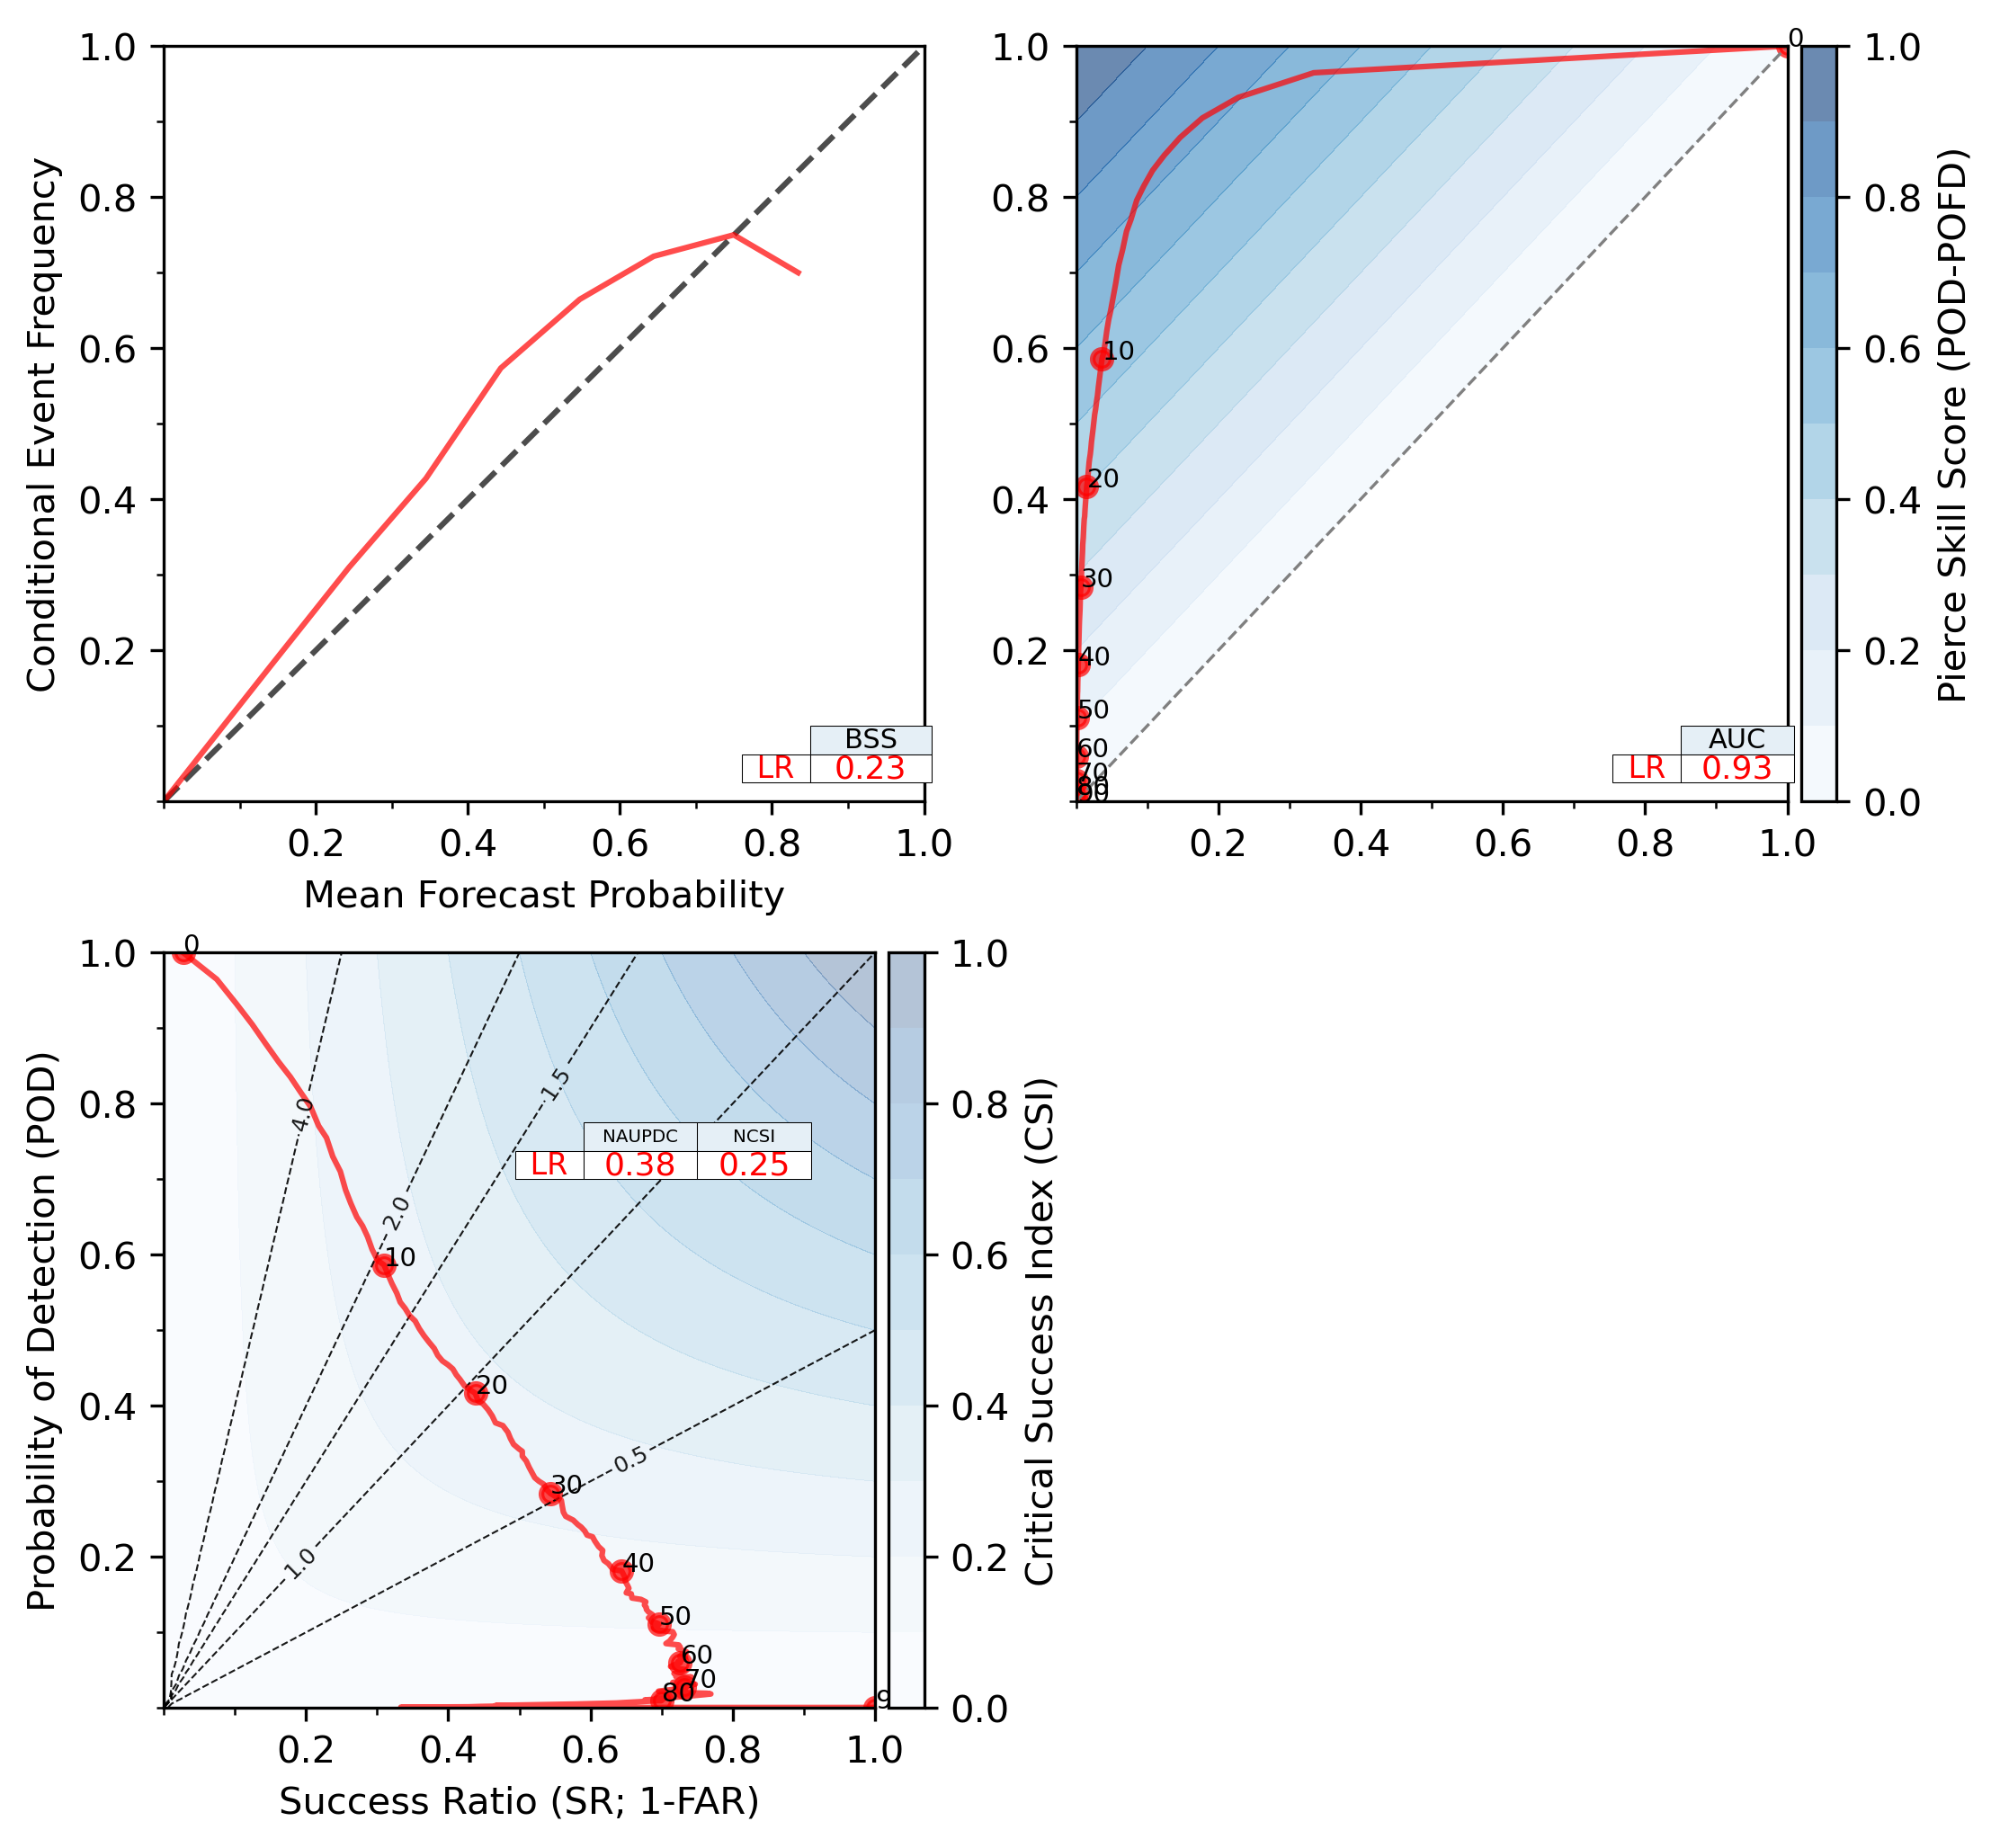

In [5]:
%matplotlib inline

X_test = X[features]
X_test = fix_data(X_test)
#X_test = get_numeric_init_time(X_test)

y_test = y.values
y_pred = [model.predict_proba(X_test)[:,1] for model in models]#[:-1]]
#bl_pred = [models[-1].predict(X_bl.reshape(-1,1))]

#y_pred += bl_pred

names = ['LR']#, 'BL'] #['RF', 'LR', 'XB', 'BL']
plot_verification(y_test, y_pred, names, n_boot=1)

In [ ]:
np.mean(y_test)*100. #, hail_severe_0km : 2.712317140146787
#np.mean(y_test)*100.#, hail_severe_original: 3.330171251685057

In [ ]:
np.max(y_pred)

In [ ]:
np.mean(y_test)*100.

In [ ]:
X_test.shape

In [ ]:
list(X_test.columns)